# 基于卷积网络的验证码识别

本文主要介绍了使用keras来构建卷积网络模型，对验证码进行识别。本文主要过程分为三部分：

1. 使用captcha包来生成随机的单字符验证码并进行裁剪作为训练数据集
2. 构建一个VGG-Like的卷积网络模型，进行训练
3. 使用模型识别验证码

本文的代码可以在[github](https://github.com/snowhyzhang/yukino/tree/master/captcha_recoginition)上找到。

## 生成验证码数据

### 观察验证码数据

In [2]:
import string
import numpy as np
import matplotlib.pyplot as plt
import keras
from PIL import Image
from captcha.image import ImageCaptcha

首先看下使用`captcha`包来生成一张“1234”的验证码图的效果。

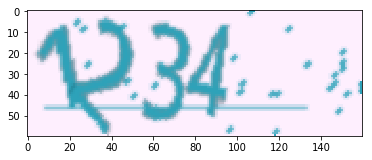

In [3]:
image = ImageCaptcha()
# 生成1234的验证码图
captcha = image.generate('1234')
captcha_image = Image.open(captcha)
arr = np.array(captcha_image)
# 将R、G、B的值转换到0-1之间
arr = arr / 255
# 展示验证码图片
plt.imshow(arr)
plt.show()

这里的主要思路是生成单个字符的验证码，然后裁剪到适合的大小作为输入数据。观察下来，在图片宽度上可以选取前30个像素，生成一张高位60，宽为30的图片作为训练数据。

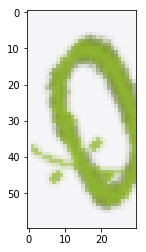

In [4]:
captcha = image.generate('0')
captcha_image = Image.open(captcha)
arr = np.array(captcha_image)
arr = arr / 255
plt.imshow(arr[:, :30, :])
plt.show()

### 处理数据集

我们采用的字符集为a-z、A-Z和0-9共62个字符，从这些字符集中随机选取若干个，生成一张验证码图片。

In [5]:
# 设定字符集
vocabulary = list(string.digits + string.ascii_letters)

def generate_captcha_array(num, size=1):
    """
    生成长度为size，数量为num的验证码图片数据集与其对应的标签 
    
    :param num: 生成验证码数据的数据量
    :param size: 验证码长度
    :return: 验证码图片数据，验证码标签
    """
    image = ImageCaptcha()
    X_data, y_data = [], []
    for _ in range(num):
        captcha_code = ''.join(np.random.choice(vocabulary, size=size))
        captcha = image.generate(captcha_code)
        captcha_image = Image.open(captcha)
        arr = np.array(captcha_image)
        arr = arr / 255
        
        X_data.append(arr)
        y_data.append(captcha_code)
    
    return np.array(X_data), np.array(y_data)


将验证码标签处理成one-hot编码。

In [6]:
# 将字符集映射到索引，以便转换为one-hot编码
vocabulary_mapper = {v: i for i, v in enumerate(vocabulary)}

def encoder_label(y_label):
    """
    将数据标签转换为one-hot编码
    
    :param y_label: 数据标签
    :return: one-hot编码
    """
    # 获取字符的索引
    y_label_code = np.array([vocabulary_mapper[y] for y in y_label])
    # 转为one-hot编码
    y_label_encoder = keras.utils.to_categorical(y_label_code, num_classes=len(vocabulary))
    return y_label_encoder

def decode_label(y_label_encoder):
    """
    将数据从one-hot编码解码为相应的标签
    
    :param y_label_encoder: one-hot编码
    :return: 数据标签
    """
    return [vocabulary[x] for x in np.where(y_label_encoder == 1)[1]]

预处理验证码图片数据和标签。

In [7]:
def preprocess_data(X_data, y_data):
    """
    预处理数据集：
    1. 将数据集进行裁剪
    2. 转为one-hot编码
    
    :param X_data: 验证码图片数据
    :param y_data: 数据标签
    :return: 预处理完的数据及标签
    """
    X_data_out = X_data[..., :30, :]
    y_data_encoder = encoder_label(y_data)
    
    return X_data_out, y_data_encoder

### 生成数据集

一共生成25000张验证码，其中15000张作为训练集，5000张作为开发集（验证集），5000张作为测试集。

In [8]:
# 生成训练集、开发集（验证集）和测试集
X_train, y_train = generate_captcha_array(15000)
X_dev, y_dev = generate_captcha_array(5000)
X_test, y_test = generate_captcha_array(5000)

In [9]:
# 预处数据集
X_train_processed, y_train_processed = preprocess_data(X_train, y_train)
X_dev_processed, y_dev_processed = preprocess_data(X_dev, y_dev)
X_test_processed, y_test_processed = preprocess_data(X_test, y_test)

## 卷积网络模型

In [10]:
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.models import Model
from keras.callbacks import TensorBoard
import time

### 构建模型
构建一个VGG-Like的卷积网络。这里是使用了一个3层卷积层和2层全链层的网络架构。

In [11]:
# 输入为高60，宽30的验证码图片
inputs = Input(shape=(60, 30, 3))

# 卷积层
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
# max pooling层
max_pool1 = MaxPooling2D((2, 2))(conv1)
# 加入Dropout
dropout1 = Dropout(0.25)(max_pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(dropout1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
max_pool2 = MaxPooling2D((2, 2))(conv2)
dropout2 = Dropout(0.25)(max_pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
max_pool3 = MaxPooling2D((2, 2))(conv3)
dropout3 = Dropout(0.25)(max_pool3)

flattern_output = Flatten()(dropout3)

# 全链层
dense = Dense(512, activation='relu')(flattern_output)
dense = Dense(256, activation='relu')(dense)

# 输出层，激活函数使用softmax
outputs = Dense(len(vocabulary), activation='softmax')(dense)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 训练模型

使用`tensorborad`来监控建模过程中的Loss与准确率。这里设置的epochs为50，mini batch size为64。

In [12]:
# 配置tensorboard回调
tensorboard = TensorBoard(log_dir='./models/%s' % time.strftime("%Y-%m-%d_%H-%M-%S"), 
                          histogram_freq=0, write_graph=True)

# 训练模型
model.fit(X_train_processed, y_train_processed, 
          validation_data = (X_dev_processed, y_dev_processed),
          epochs=50, verbose=0, batch_size=64, callbacks=[tensorboard])

### 分析模型的Loss与准确率

在`tensorborad`上查看模型Loss的变化，在训练了50个epochs后，模型的Loss已经达到一个较低的值，而查看开发集的Loss，其稍大于训练集上产生的Loss，因此，模型存在轻微的过拟合现象。

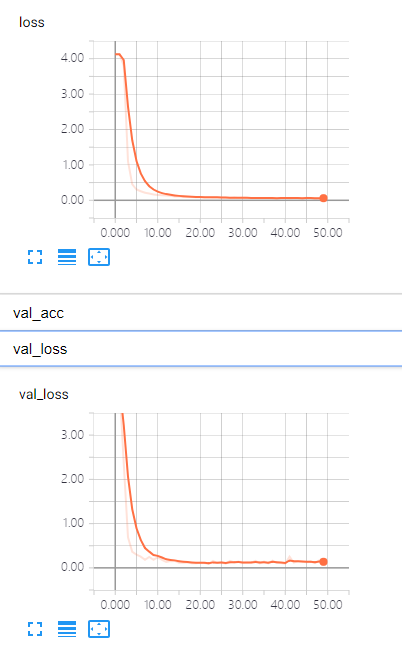

In [7]:
from IPython.display import Image, HTML

Image(filename="loss_track.png")

训练集的准确率为98%左右，开发集的准确率在95%左右，虽然存在轻微的过拟合，但是开发集的准确率也是可以接受的，因此暂时先不考虑做一进步优化，可以作为第一个版本的模型在测试集上进行预测，查看其在测试集上的性能表现。

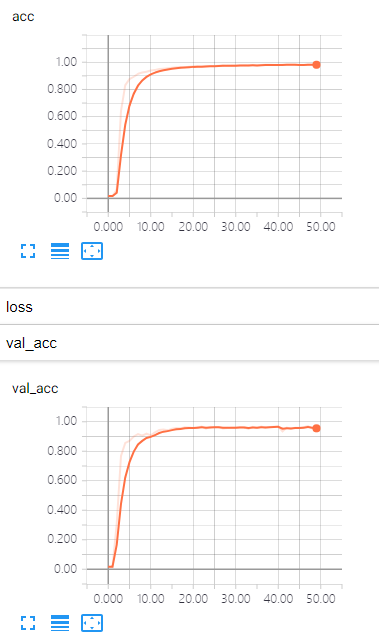

In [6]:
Image(filename="acc_track.png")

### 模型在测试集上的性能表现

In [13]:
prediction = model.predict(X_test_processed)
correct_prediction = np.equal(np.argmax(y_test_processed, axis=1), np.argmax(prediction, axis=1)).sum()
acc_rate =  correct_prediction / np.size(prediction, axis=0) 
print('test acc rate %.2f%%' % (acc_rate * 100))

test acc rate 95.46%


模型在测试集上的准确率也达到了95%，与开发集相当。  
虽然达到95%的准确是可以接受的，但是可以在网络的规模，正则化等方面进行优化，进一步提升模型的性能。

## 生成验证码测试模型

生成一个“1024”的验证码，这里以30个像素为宽度，对图像进行简单的切分，对每个字符进行预测，然后输出最终的预测结果。

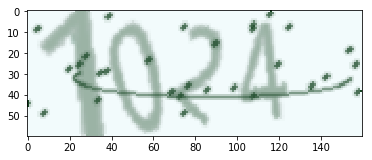

predict: 1024


In [14]:
predict_text = '1024'
captcha = image.generate(predict_text)
captcha_image = Image.open(captcha)
X = np.array(captcha_image)
X = X / 255
    
predict_result = []
for i in range(len('1024')):
    start_index = i * 30
    end_index = (i + 1) * 30
    X_cut = X[:, start_index:end_index, :]
    X_cut = X_cut.reshape(-1, 60, 30, 3)
    prediction_X_cut = model.predict(X_cut)
    predict_result.append(vocabulary[np.argmax(prediction_X_cut)])

plt.imshow(X)
plt.show()

print('predict: %s' % ''.join(predict_result))